# Evaluating SETI detection performance with swept parameters
This notebook runs multiple instances of notebook "01_seti_end_to_end.ipynb", which does the following:
1) Inputs a single RAW file 
2) Runs Rawspec to generate a filterbank .h5 spectrogram file with specified fine FFT size and integration factor
3) Runs TurboSETI and/or seticore and compiles a list of detections and compute time (wall clock)

The primary sweep parameters are 
1) FFT size (which determines frequency resolution and equivalent noise bandwidth)
2) Short Term Integration (Pre-DeDoppler) spectrogram averaging parameter n_sti (aka int_factor or N_preDD)

This notebook is intended to work with special chirp test files created by 00_multichirp_raw_file_gen.ipynb (in seti_test_file_gen repository), 
which inserts a large number of chirp signals covering a wide range of drift rates. Parameters for GBT, MeerKAT, or COSMIC may be selected.
See https://github.com/khouston22/seti_test_file_gen.

Note that these sweeps can be done with various branches of seticore or seticore2 and detection SNR or timing comparisons
can be made between branches over multiple runs of this notebook.  For each run of this notebook, 
the desired seticore branch needs to be checked out and compiled, and 
the string "test_case" needs to be set in 01_seti_end_to_end.ipynb to indicate the branch.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import array
%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import src.plot_fns as pltg             # generic plot fns
import src.plot_h5_psd_sg1 as plt_h5    # blimpy-based plot fns

parameters_are_undefined = False

verbose = False
fb_ext = '.h5'

raw_dir = os.getenv('RAWDIR') + '/'
if not os.path.isdir(raw_dir[0:-1]):
    os.system('mkdir '+raw_dir[0:-1])

raw_backup_base_dir = os.getenv('RAW_BACKUP_BASE_DIR') + '/'

def file_name_mjd(raw_file_stem):
    # specific to guppi file naming conventions
    stem_parts = raw_file_stem.split('_')
    if (len(stem_parts)<4):
         mjd_int = 99999
    elif (stem_parts[1]=='guppi'):
        mjd_int = int(stem_parts[2])
    elif (stem_parts[2]=='guppi'):
        mjd_int = int(stem_parts[3])
    else:
        mjd_int = 99999
    #print(mjd_int)   
    return mjd_int


In [2]:
try:
    raw_files_are_undefined
except NameError:
    raw_files_are_undefined = True     
    print('Raw files are undefined, using defaults\n')

app_to_run = 'seticore-10'

display_figs01 = False
display_figs02 = True
plot_all_dets = False
plot_multichirp_dets1 = False
plot_multichirp_dets2 = True
plot_sg_psd_zoom = False
plot_psd_zoom = False
plot_sg_zoom = False
plot_sg_wb = False
plot_psd_wb = False
zoom_bw_MHz = .012  # +/- 6 KHz
max_n_zoom_plots = 100

do_fig_text_only = True   # True normally, False to generate copy of figures without text for pubs
search_max_drift = 10.
search_min_drift = -10.

if raw_files_are_undefined:
    if (1):
        npz_file = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-sc2-10.npz'
    

                
print(f'{npz_file = }')

delete_h5_sg_file = True        # =True h5 sg file will be deleted after finishing (reduce file space in $SGDIR)
delete_raw_file_enable = False  # Must be False for this notebook: will keep raw file in $RAWDIR regardless
enable_raw_backup_copy = True   # Must be True for this notebook: copy to $RAWDIR if needed from $RAW_BACKUP_BASE_DIR/raw_backup_subdir

run_turbo = False

if do_fig_text_only:
    n_fig_copies = 1
else:
    n_fig_copies = 2    # second copy created without text in plot area

# drift_limit_nHz = 1.0  # assume 2 sigma limit
# f_sigma_drift = np.array([1.5, 3, 6])*1e9
# sigma_drift = drift_limit_nHz*f_sigma_drift/2.*1e-9
# print(f'sigma_drift = {sigma_drift}')


Raw files are undefined, using defaults

npz_file = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-sc2-10.npz'


#### Run end-to-end test over parameter sweeps

In [3]:
isChirp = npz_file.lower().find('chirp')>=0
isVoyager = npz_file.lower().find('voyager')>=0
isguppi = npz_file.lower().find('guppi')>=0

if isChirp:
    raw_parts_list = npz_file.split('-')
    telescope = raw_parts_list[0]
    
    if (npz_file.lower().find('gbt')>=0):    # GBT/Parkes HSR2A, but 512 avg rather than 51*16=816 avg (183 sec vs 292)
    
        fig_dir = './chirp_gbt_plots/'

    elif(npz_file.lower().find('meerkat')>=0):   # MeerKAT 1K mode
    
        fig_dir = './chirp_mk_plots/'
    
    elif(npz_file.lower().find('cosmic')>=0):  # COSMIC VLA
    
        fig_dir = './chirp_cosmic_plots/'
    
else:
    print(f'Note: special chirp file expected, skipping execution\n')
    # stop, or return to calling notebook/script
    assert(False)

print(f'Figures will appear in in {fig_dir}')

os.system('mkdir '+fig_dir)

npz_file = fig_dir + npz_file

Figures will appear in in ./chirp_gbt_plots/


mkdir: cannot create directory ‘./chirp_gbt_plots/’: File exists


#### Store results in npz file for later recall

In [4]:
# # Write the data to a np savez file
# z_name = fig_dir + raw_file_stem + '-' + test_case + ".npz"
# print('Writing results to file',z_name)
# np.savez_compressed(z_name,p=p,test_case=test_case,fine_fft_size_list=fine_fft_size_list,
#                     n_sti_list=n_sti_list,n_lti_list=n_lti_list,T_avg_list=T_avg_list,telescope=telescope,
#                     samples_per_block=p['samples_per_block'],search_max_drift=search_max_drift,
#                     search_min_drift=search_min_drift,search_z_threshold=search_z_threshold,
#                     select_params=select_params,select_params2=select_params2,
#                     f_sigma_drift=f_sigma_drift,sigma_drift=sigma_drift,
#                     run_turbo=run_turbo,run_seticore=run_seticore,search_app_name=search_app_name,
#                     time_rawspec=time_rawspec,time_search=time_search,
#                     time_search_total=time_search_total,time_run=time_run,
#                     f_start_truth_all=f_start_truth_all,drift_rate_truth_all=drift_rate_truth_all,
#                     ref_snr_db_all=ref_snr_db_all,n_det_all=n_det_all,
#                     n_det1=n_det1,det_f_start_MHz_all=det_f_start_MHz_all,
#                     det_drift_rate_all=det_drift_rate_all,det_snr_db_all=det_snr_db_all,
#                     dechirp_eff_db_all= dechirp_eff_db_all,dechirp_eff_pct_all=dechirp_eff_pct_all,
#                     N_spread_all=N_spread_all,
#                     pred_dechirp_eff_pct_all=pred_dechirp_eff_pct_all,pred_dechirp_eff_db_all=pred_dechirp_eff_db_all,
#                     pred_sqrt_dechirp_eff_pct_all=pred_sqrt_dechirp_eff_pct_all,pred_sqrt_dechirp_eff_db_all=pred_sqrt_dechirp_eff_db_all,
#                     det_snr_db_wavg_all=det_snr_db_wavg_all,dechirp_eff_pct_wavg_all=dechirp_eff_pct_wavg_all,
#                     raw_size_MB=raw_size_MB,
#                     h5_size_MB_all=h5_size_MB_all,n_coarse_channels=n_coarse_channels)

# # copy text output into figure directory
# out_name = fig_dir + raw_file_stem + '-' + test_case + ".out"
# os.system('cp seticore_text_all.out ' + out_name)

In [5]:
%run -i "src/load_chirp_npz.py"

In [6]:
p

{'raw_file_stem': 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec',
 'raw_size_MB': 16384.875,
 'n_raw_files': 1,
 'telescop': 'GBT     ',
 'time_string': 'Tue Sep 22 00:24:27 2020',
 'mjd_day': 59114,
 'src_name': 'TMC1    ',
 'ra_deg': 70.4408,
 'dec_deg': 25.6911,
 'ctr_freq_MHz': 6004.39453125,
 'obs_bw_MHz': 11.71875,
 'obs_bw_sign': 1,
 'chan_bw': 2929687.5,
 'f_min_MHz': 5998.53515625,
 'f_max_MHz': 6010.25390625,
 'fch1': 6000.0,
 'foff': 1.396983861923219,
 't_obs': 366.503875925333,
 'n_antennas': 1,
 'n_coarse_channels': 4,
 'n_pols': 2,
 'n_bits': 8,
 'fs_coarse': 2929687.500000003,
 'fine_fft_size': 2097152,
 'n_sti': 64,
 'n_lti': 8.0,
 'n_avg': 512.0,
 't_coarse': 3.41333333333333e-07,
 't_fine': 0.715827882666666,
 't_res': 45.81298449066662,
 'n_coarse_samples': 1073741824.0,
 'n_fine_samples': 512.0,
 'fs_fine': 1.396983861923219,
 'samples_per_block': 8388608.0,
 'n_blocks': 128,
 'n_blocks_base': 128,
 'block_size': 134217728,
 'obs_time_per_block': 

#### Plot composite results: SNR vs Drift Rate

Note: test_case string is defined within 01_seti_end_to_end

In [7]:
if isChirp:
    for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
            
        fine_fft_size_K = fine_fft_size/1024
        ref_snr_db = ref_snr_db_all[0,i_fft,0]
        
        intf_legend = ['']*len(n_sti_list)
        for i_sti, n_sti in enumerate(n_sti_list):
            n_lti = n_lti_list[i_fft,i_sti]
            intf_legend[i_sti] = f'{n_sti=:2d}, {n_lti=:2.0f}'

        fig_text_list1=[[.15,.85,raw_file_stem],
                                [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
                                [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_db_wavg_all[i_fft,:,-1],precision=1) + ' dB'],
                                [.15,.76,f'Total  '+ np.array2string(time_search_total[i_fft,:],precision=2) + ' sec']]
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[drift_rate_truth_all[:,i_fft,0],det_drift_rate_all[:,i_fft,:]],
                y_data=[ref_snr_db_all[:,i_fft,0],det_snr_db_all[:,i_fft,:]],
                xy_markers = ['-','*'],
                xy_legend = ['Reference',intf_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                # y_limits=[0., 40.],
                y_limits=[5., np.amax((45.,5.*np.ceil(ref_snr_db/5)+5.))],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' Seticore Drifting Tone Detections, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '11-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'
        


/home/kmh4005/Dropbox/kgit/seti_end_to_end/src/plot_fns.py:89: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [8]:
if isChirp:
    for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
            
        fine_fft_size_K = fine_fft_size/1024
        ref_snr_db = ref_snr_db_all[0,i_fft,0]
        reference_str = f'Reference={ref_snr_db:.2f} dB'

        intf_legend = ['']*len(n_sti_list)
        for i_sti, n_sti in enumerate(n_sti_list):
            n_lti = n_lti_list[i_fft,i_sti]
            intf_legend[i_sti] = f'{n_sti=:2d}, {n_lti=:2.0f}'

        drift_rate_truth = drift_rate_truth_all[:,i_fft,0]

        prob_weight = 10*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
        prob_legend = ['']*len(sigma_drift)
        for i_cfreq,cfreq in enumerate(f_sigma_drift):
                prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

        fig_text_list1=[[.15,.85,raw_file_stem]]
        # fig_text_list1=[[.15,.85,raw_file_stem],
        #     [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
        #     [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_db_wavg_all[i_fft,:,-1],precision=1) + ' dB'],
        #     [.15,.76,f'Total  '+ np.array2string(time_search_total[i_fft,:],precision=2) + ' sec']]

        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate_all[:,i_fft,:],drift_rate_truth],
                y_data=[ref_snr_db_all[:,i_fft,0],det_snr_db_all[:,i_fft,:],prob_weight],
                xy_markers = ['-','*','--'],
                xy_legend = [reference_str,intf_legend,prob_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 45.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' {search_app_string} Drifting Tone Detections, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '12-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'
         


#### Do plots for selected FFT and n_sti combinations

In [9]:
if isChirp:
    n_select = len(select_params)
    select_legend = ['']*n_select
    det_drift_rate_select = np.ones((n_det_max,n_select))*np.nan
    det_snr_db_select = np.ones((n_det_max,n_select))*np.nan
    h5_size_MB_select = np.ones((n_select))*np.nan
    time_search_total_select = np.ones((n_select))*np.nan
    det_snr_wavg_db_select = np.ones((n_select))*np.nan
    print(f'{select_params =}')
    print(f'{fine_fft_size_list =}')
    print(f'{n_sti_list =}')
    
    for i_select, s_params in enumerate(select_params):
            
        fine_fft_size = s_params[0]
        n_sti = s_params[1]

        fine_fft_size_K = fine_fft_size/1024
        
        i_fft  = np.where(fine_fft_size_list==fine_fft_size)[0][0]
        i_sti = np.where(n_sti_list==n_sti)[0][0]
        
        # reference will be for last FFT size selected
        ref_snr_db = ref_snr_db_all[0,i_fft,0]
        reference_str = f'Reference={ref_snr_db:.2f} dB'

        n_lti = n_lti_list[i_fft,i_sti]
        select_legend[i_select] = f'{fine_fft_size_K:.0f}K, {n_sti=:2.0f}, {n_lti=:2.0f}'

        try:
            det_drift_rate_select[:,i_select] = det_drift_rate_all[:,i_fft,i_sti]
            det_snr_db_select[:,i_select] = det_snr_db_all[:,i_fft,i_sti]
            h5_size_MB_select[i_select] = h5_size_MB_all[i_fft,i_sti]
            time_search_total_select[i_select] = time_search_total[i_fft,i_sti]
            det_snr_wavg_db_select[i_select] = det_snr_db_wavg_all[i_fft,i_sti,-1]
        except:
            print(f'Select parameters {s_params} out of range')

    prob_weight = 10*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
    prob_legend = ['']*len(sigma_drift)
    for i_cfreq,cfreq in enumerate(f_sigma_drift):
            prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

    fig_text_list1=[[.15,.85,raw_file_stem]]
    # fig_text_list1=[[.15,.85,raw_file_stem],
    #             [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
    #             [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_wavg_db_select,precision=2) + ' dB'],
    #             [.15,.76,f'Total  '+ np.array2string(time_search_total_select,precision=2) + ' sec']]

    ext_str = '.png'
    for i_plot in range(n_fig_copies):
        pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate_select,drift_rate_truth],
            y_data=[ref_snr_db**np.ones(np.size(drift_rate_truth)),det_snr_db_select,prob_weight],
            xy_markers = ['-','*','--'],
            xy_legend = [reference_str,select_legend,prob_legend],
            x_limits=[sig_min_drift-1,sig_max_drift+1],
            y_limits=[0., 45.],
            x_label = 'Drift Rate (Hz/sec)',
            y_label = 'SNR(dB)',
            fig_title= telescope.upper() + f' {search_app_string} Selected Detections, {t_obs:.1f} sec  '+test_case,
            fig_text_list=fig_text_list1,
            legend_loc = 'upper right',
            display_fig=display_figs02,
            savfig_name=fig_dir + '14-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-det-'+test_case+ext_str)
        fig_text_list1 = [] # do copy of plot without text in figure plot area
        ext_str = 'nt.png'
        
    


select_params =array([[1048576,      32],
       [1048576,       4],
       [1048576,       2],
       [1048576,       1]])
fine_fft_size_list =array([ 524288, 1048576, 2097152])
n_sti_list =array([ 1,  2,  4,  8, 16, 32, 64])


#### Do additional plots for selected FFT and n_sti combinations

In [10]:
if isChirp:
    try:
        n_select = len(select_params2)
    except:
        n_select = 0
    if (n_select>0):
        select_legend = ['']*n_select
        det_drift_rate_select = np.ones((n_det_max,n_select))*np.nan
        det_snr_db_select = np.ones((n_det_max,n_select))*np.nan
        h5_size_MB_select = np.ones((n_select))*np.nan
        time_search_total_select = np.ones((n_select))*np.nan
        det_snr_wavg_db_select = np.ones((n_select))*np.nan
        print(f'{select_params =}')
        print(f'{fine_fft_size_list =}')
        print(f'{n_sti_list =}')
        
        for i_select, s_params in enumerate(select_params2):
                
            fine_fft_size = s_params[0]
            n_sti = s_params[1]

            fine_fft_size_K = fine_fft_size/1024
            
            i_fft  = np.where(fine_fft_size_list==fine_fft_size)[0][0]
            i_sti = np.where(n_sti_list==n_sti)[0][0]
            
            # reference will be for last FFT size selected
            ref_snr_db = ref_snr_db_all[0,i_fft,0]
            reference_str = f'Reference={ref_snr_db:.2f} dB'
            
            n_lti = n_lti_list[i_fft,i_sti]
            select_legend[i_select] = f'{fine_fft_size_K:.0f}K, {n_sti=:2.0f}, {n_lti=:2.0f}'

            try:
                det_drift_rate_select[:,i_select] = det_drift_rate_all[:,i_fft,i_sti]
                det_snr_db_select[:,i_select] = det_snr_db_all[:,i_fft,i_sti]
                h5_size_MB_select[i_select] = h5_size_MB_all[i_fft,i_sti]
                time_search_total_select[i_select] = time_search_total[i_fft,i_sti]
                det_snr_wavg_db_select[i_select] = det_snr_db_wavg_all[i_fft,i_sti,-1]
            except:
                print(f'Select parameters {s_params} out of range')

        prob_weight = 10*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
        prob_legend = ['']*len(sigma_drift)
        for i_cfreq,cfreq in enumerate(f_sigma_drift):
            prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

        fig_text_list1=[[.15,.85,raw_file_stem]]
        # fig_text_list1=[[.15,.85,raw_file_stem],
        #                 [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
        #                 [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_wavg_db_select,precision=1) + ' dB'],
        #                 [.15,.76,f'Total  '+ np.array2string(time_search_total_select,precision=2) + ' sec']]
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate_select,drift_rate_truth],
                y_data=[ref_snr_db**np.ones(np.size(drift_rate_truth)),det_snr_db_select,prob_weight],
                xy_markers = ['-','*','--'],
                xy_legend = [reference_str,select_legend,prob_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 45.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' {search_app_string} Selected Detections, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '15-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'

select_params =array([[1048576,      32],
       [1048576,       4],
       [1048576,       2],
       [1048576,       1]])
fine_fft_size_list =array([ 524288, 1048576, 2097152])
n_sti_list =array([ 1,  2,  4,  8, 16, 32, 64])


#### Plot composite SNR vs compute time curves

sigma_drift = [0.75 1.5  3.  ]
./chirp_gbt_plots/21-gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-2GHz-snr-time-sc2-10.png


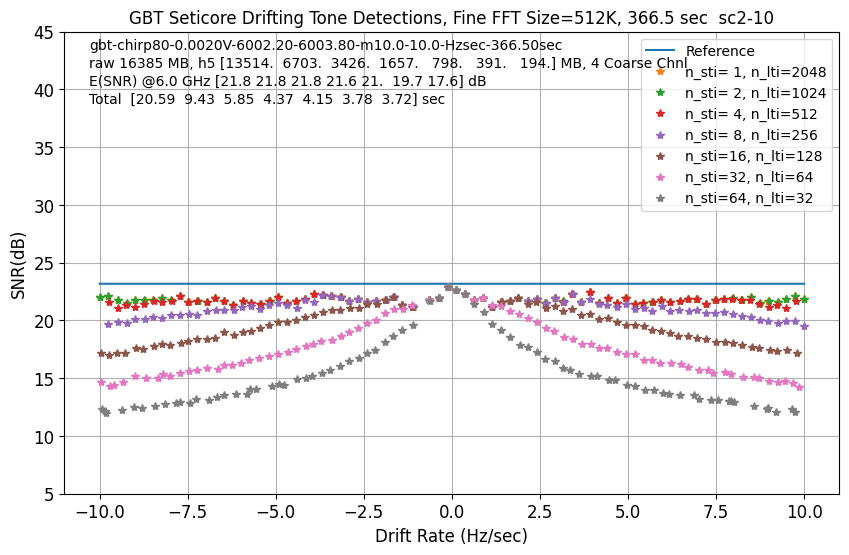

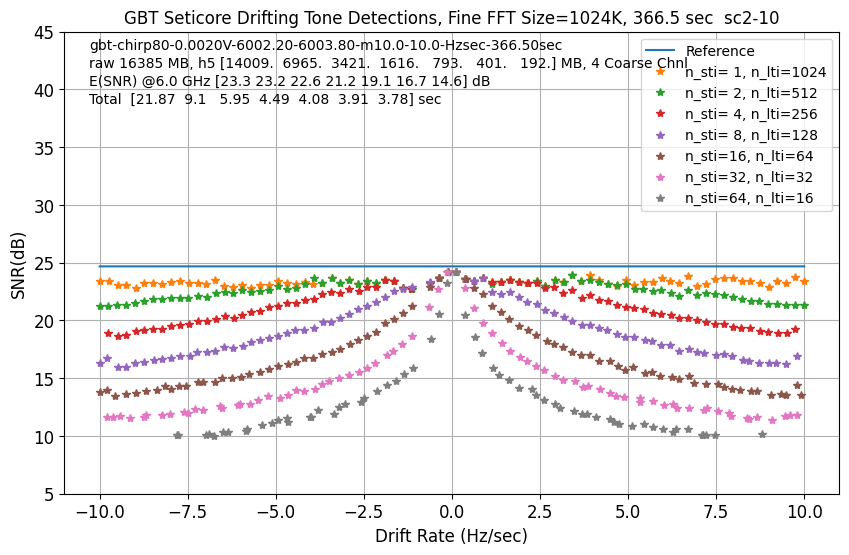

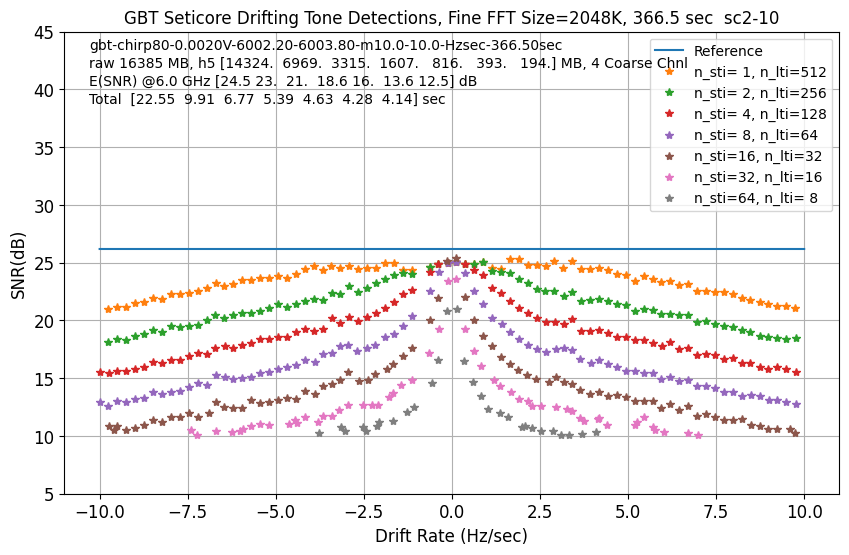

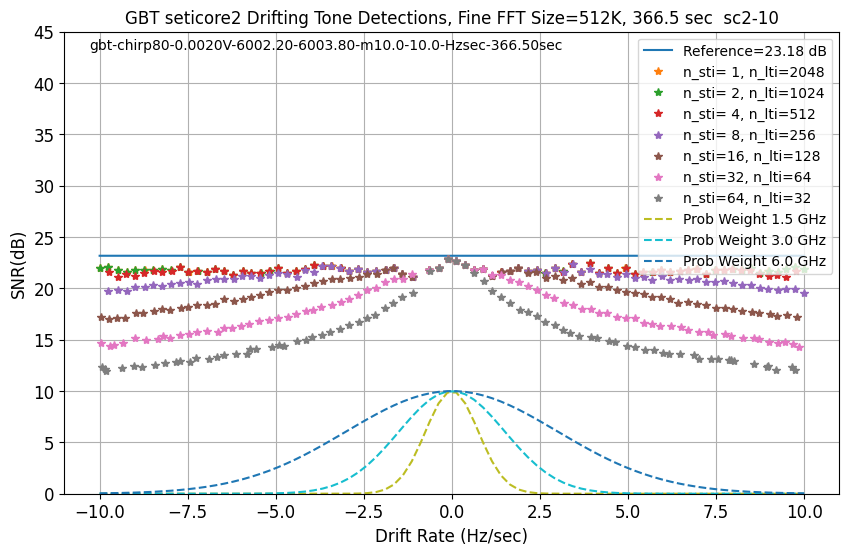

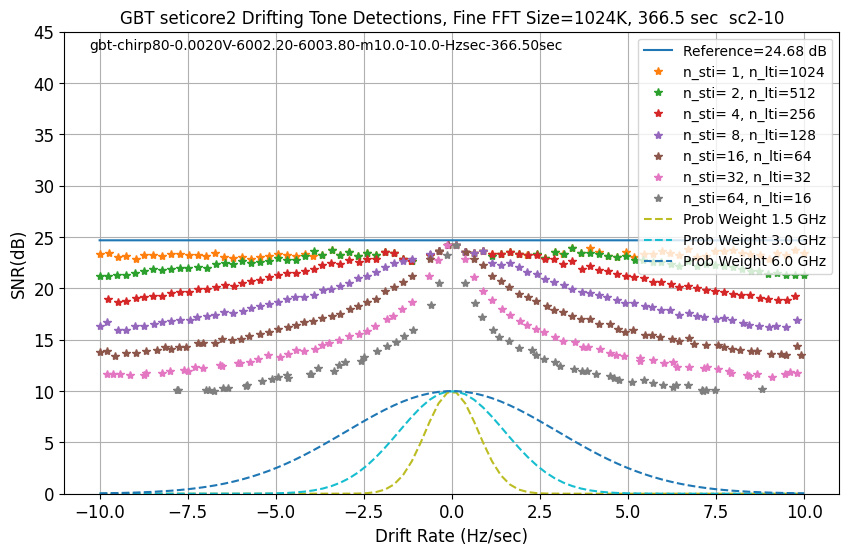

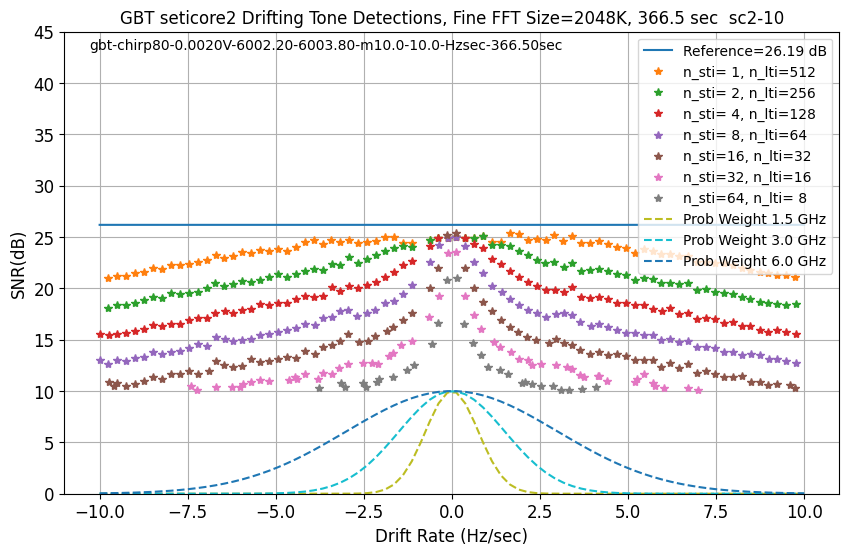

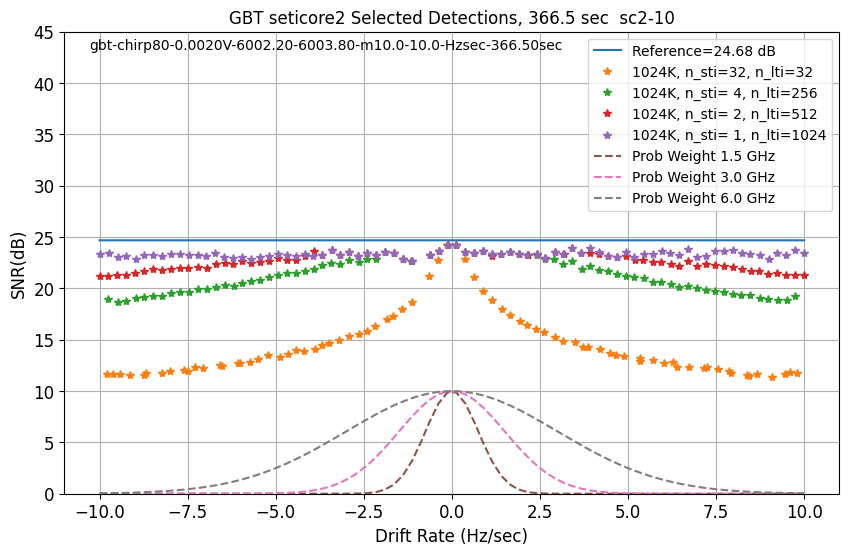

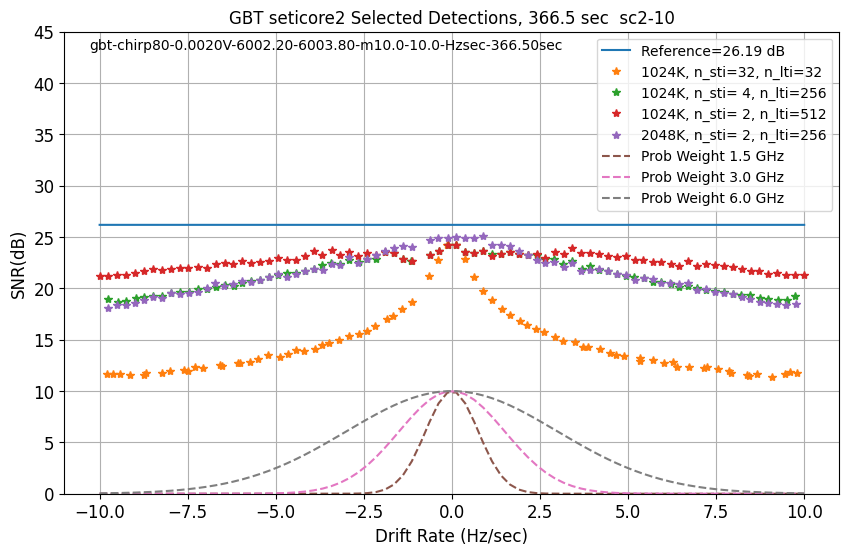

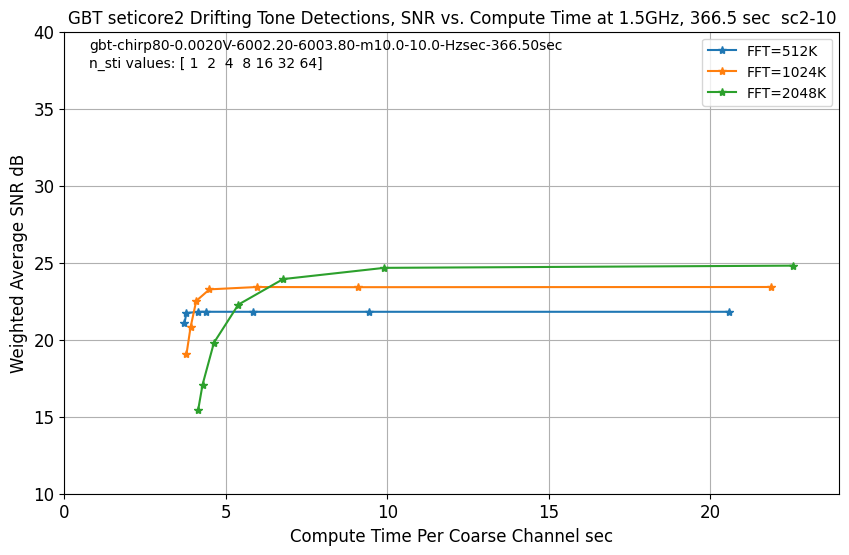

./chirp_gbt_plots/21-gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-3GHz-snr-time-sc2-10.png


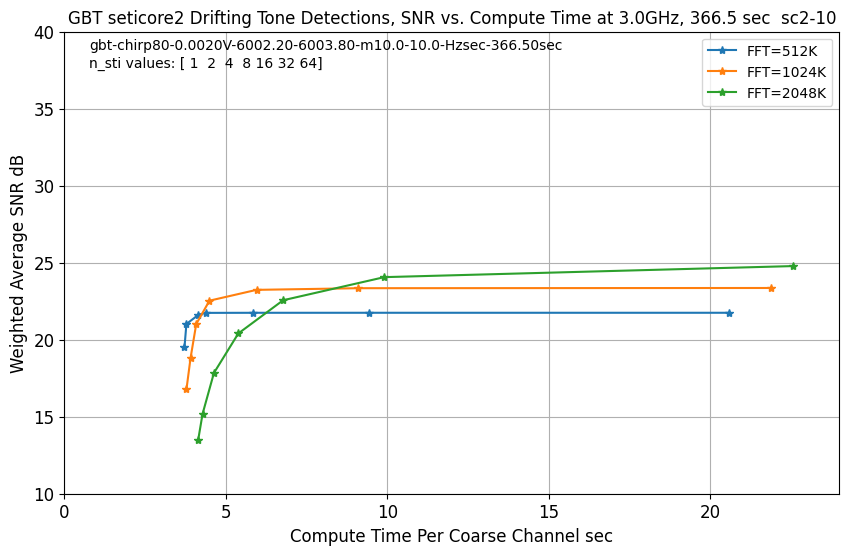

./chirp_gbt_plots/21-gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-6GHz-snr-time-sc2-10.png


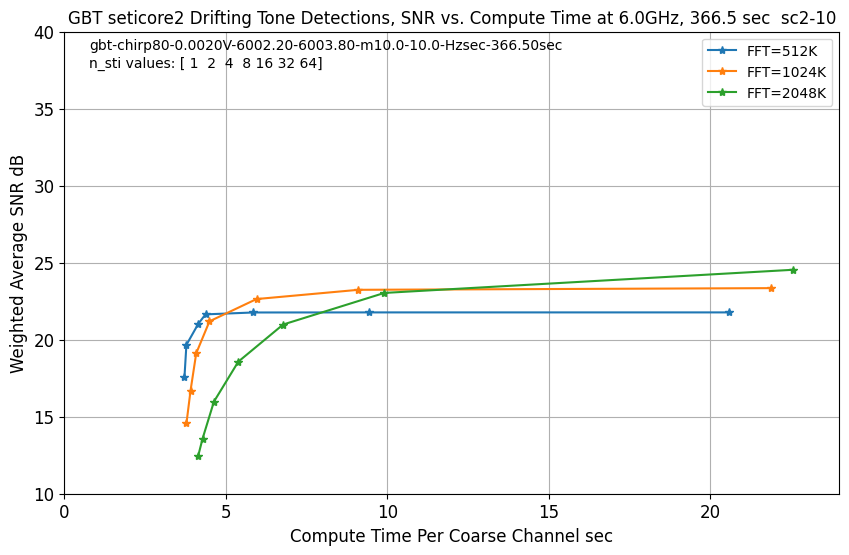

In [11]:
print(f'sigma_drift = {sigma_drift}')

if isChirp:
    %matplotlib inline
    wavg_max = np.nanmax(det_snr_db_wavg_all)
    wavg_min = np.nanmin(det_snr_db_wavg_all)
    
    for idx, sigma_drift1 in enumerate(sigma_drift):

        f_sigma_drift1 = f_sigma_drift[idx]       
        fine_fft_size_list_K = fine_fft_size_list/1024
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            
            fig = plt.figure(figsize=(10, 6))
            
            for i_fft, fine_fft_size_K in enumerate(fine_fft_size_list_K):
                plt.plot(time_search_total[i_fft,:],det_snr_db_wavg_all[i_fft,:,idx],'-*',label=f'FFT={fine_fft_size_K:.0f}K')
            
            # plt.xlim(0.,4.*np.ceil(np.nanmax(time_search_total[i_fft,:]/4.)))
            # plt.xlim(2.*np.floor(np.nanmin(time_search_total[0,:]/2.)),2.*np.ceil(np.nanmax(time_search_total[i_fft,:]/2.)))
            xlim_max = 2.*np.ceil(np.nanmax(time_search_total[:]/2.))
            if (xlim_max<10.): xlim_max=10.;
            plt.xlim(0.,xlim_max)
        
            plt.title(f'{telescope.upper()} {search_app_string} Drifting Tone Detections, SNR vs. Compute Time at {f_sigma_drift1*1e-9:.1f}GHz, {t_obs:.1f} sec  '+test_case )

            # plt.ylim(5*(np.floor((wavg_min-2)/5)),5*(np.ceil(wavg_max/5)+1))
            plt.ylim(10.,40.)
            plt.xlabel('Compute Time Per Coarse Channel sec')
            plt.ylabel('Weighted Average SNR dB')
            if i_plot==0:
                plt.figtext(.15,.85,raw_file_stem)
                # plt.figtext(.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[0,:],precision=0)+ ' MB')
                plt.figtext(.15,.82,f'n_sti values: '+ np.array2string(n_sti_list,precision=0))
            plt.legend(loc='upper right')
            plt.grid()

            fig_name = fig_dir + '21-' + raw_file_stem + f'-fctr-{f_sigma_drift1*1e-9:.0f}GHz' + '-snr-time-'+test_case+ext_str
                        
            print(fig_name)
            plt.savefig(fig_name,bbox_inches='tight')

            if display_figs02:
                plt.show()
            else:
                plt.close(fig)
                
            ext_str = 'nt.png' # for second pass, do copy of plot without text in figure plot area
        

#### Dechirping Efficiency Plots

intf_legend=['n_sti= 1, n_lti=2048', 'n_sti= 2, n_lti=1024', 'n_sti= 4, n_lti=512', 'n_sti= 8, n_lti=256', 'n_sti=16, n_lti=128', 'n_sti=32, n_lti=64', 'n_sti=64, n_lti=32']


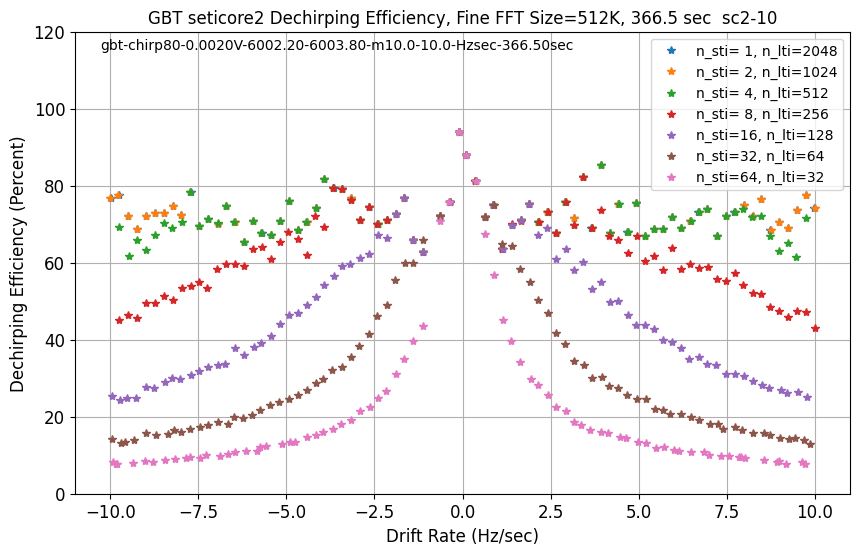

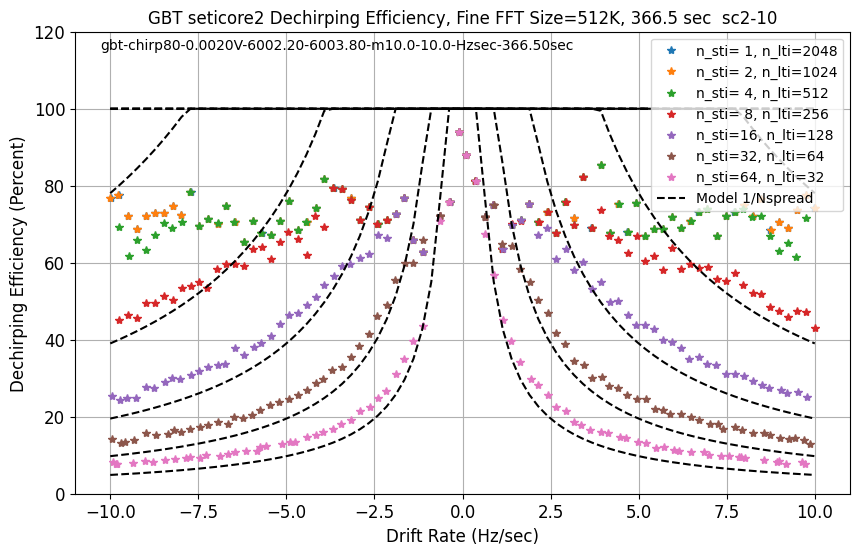

intf_legend=['n_sti= 1, n_lti=1024', 'n_sti= 2, n_lti=512', 'n_sti= 4, n_lti=256', 'n_sti= 8, n_lti=128', 'n_sti=16, n_lti=64', 'n_sti=32, n_lti=32', 'n_sti=64, n_lti=16']


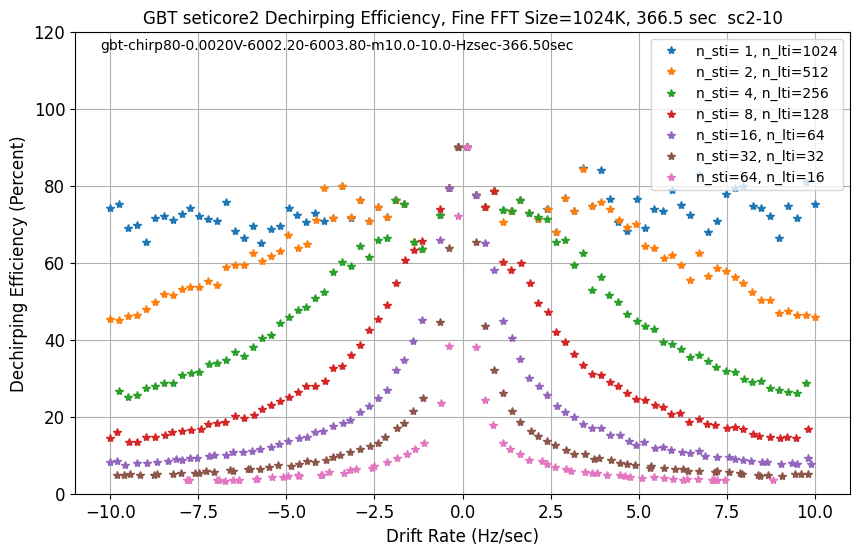

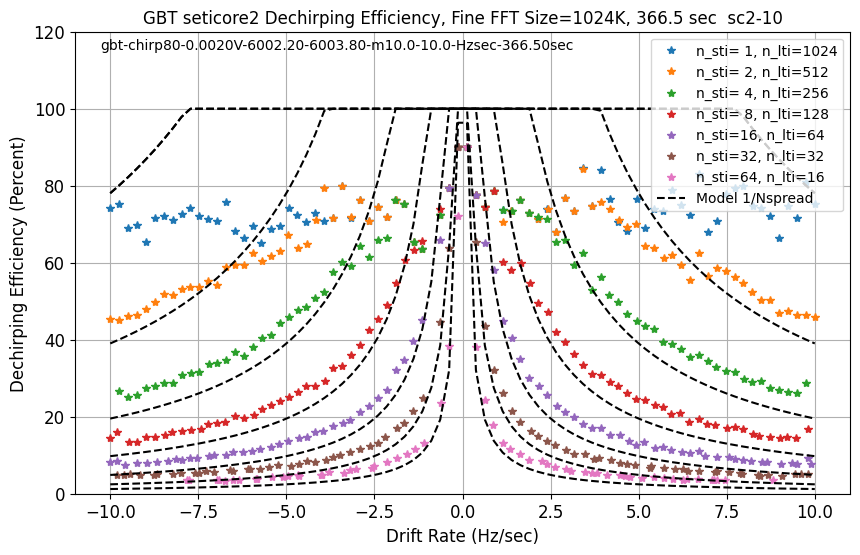

intf_legend=['n_sti= 1, n_lti=512', 'n_sti= 2, n_lti=256', 'n_sti= 4, n_lti=128', 'n_sti= 8, n_lti=64', 'n_sti=16, n_lti=32', 'n_sti=32, n_lti=16', 'n_sti=64, n_lti= 8']


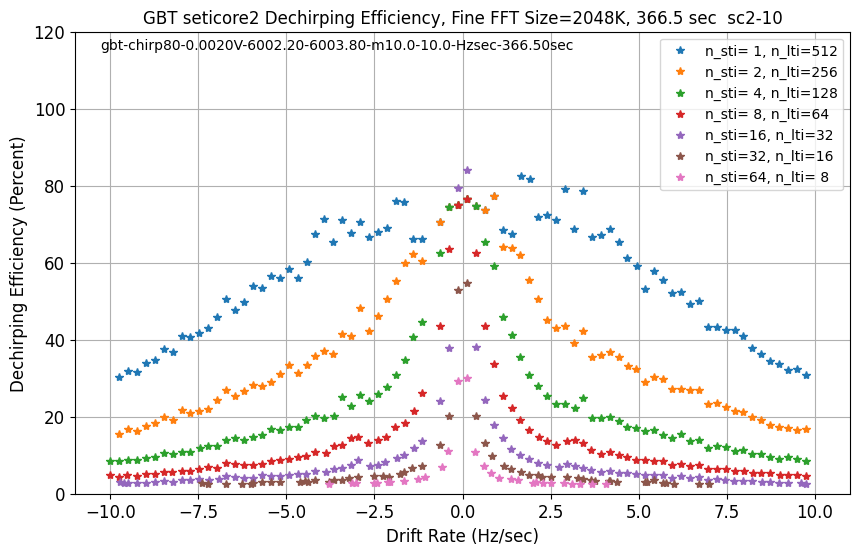

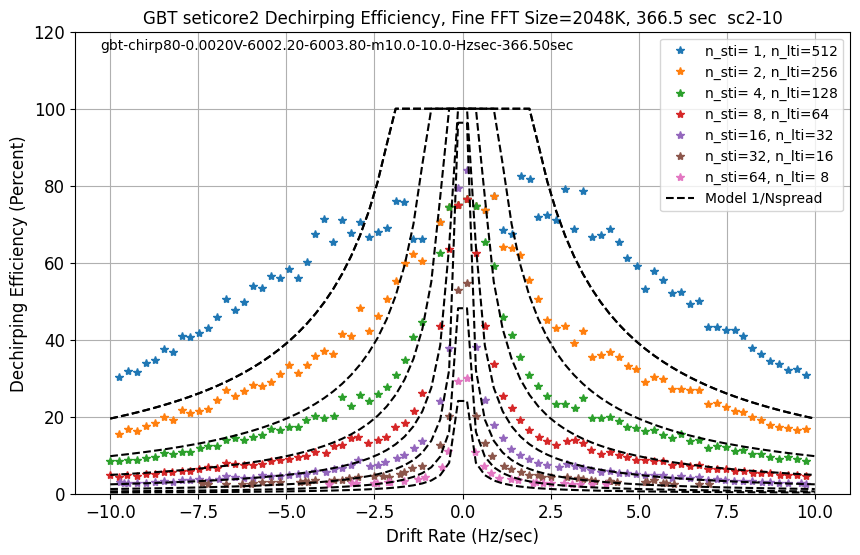

In [12]:
if isChirp:

    for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
            
        fine_fft_size_K = fine_fft_size/1024

        intf_legend = ['']*len(n_sti_list)
        for i_sti, n_sti in enumerate(n_sti_list):
            n_lti = n_lti_list[i_fft,i_sti]
            intf_legend[i_sti] = f'{n_sti=:2d}, {n_lti=:2.0f}'
        print(f'{intf_legend=}')

        drift_rate_truth = drift_rate_truth_all[:,i_fft,0]

        fig_text_list1=[[.15,.85,raw_file_stem]]
        # fig_text_list1=[[.15,.85,raw_file_stem],
        #     [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
        #     [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_db_wavg_all[i_fft,:,-1],precision=1) + ' dB'],
        #     [.15,.76,f'Total  '+ np.array2string(time_search_total[i_fft,:],precision=2) + ' sec']]

        if (raw_file_base_name.lower().find('gbt')>=0):
            if (0):
                ii = slice(0,len(n_sti_list),2)
                print(f'{ii=}')
                print(f'{intf_legend[ii]}')
            else:
                ii = slice(0,len(n_sti_list),1)
        else:
            ii = slice(0,len(n_sti_list),1)
        
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[det_drift_rate_all[:,i_fft,:]],
                y_data=[dechirp_eff_pct_all[:,i_fft,:]],
                xy_markers = ['*'],
                xy_legend = [intf_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 120.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'Dechirping Efficiency (Percent)',
                fig_title= telescope.upper() + f' {search_app_string} Dechirping Efficiency, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '16-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-det-'+test_case+ext_str)
            
            pltg.plot_generic(x_data=[det_drift_rate_all[:,i_fft,ii],drift_rate_truth,drift_rate_truth],
                y_data=[dechirp_eff_pct_all[:,i_fft,ii],pred_dechirp_eff_pct_all[:,i_fft,0],pred_dechirp_eff_pct_all[:,i_fft,ii]],
                xy_markers = ['*','--k','--k'],
                xy_legend = [intf_legend[ii],'Model 1/Nspread',''],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 120.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'Dechirping Efficiency (Percent)',
                fig_title= telescope.upper() + f' {search_app_string} Dechirping Efficiency, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '17-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'


        
    



In [13]:
print('Done')

# Beep 2 times
for i_beep in range(2):
    try:
        # Beep in WSL
        if os.system("powershell.exe '[console]::beep(261.6,700)'") !=0:
            raise Exception('powershell.exe not found')
    except:
        # linux, probably doesn't work
        print('Beep!')
        os.system("echo -ne '\a'")

Done
